# Final Project - Python Port of “nister2” Two-View Triangulation Method

**Author(s):** Azmyin Md. Kamal

**Course:** ME 7953

**Semester:** Spring 2024

**AI:** ChatGPT 4.0

## REQUIREMENTS
The following packages are requried to run this experiment
* OpenCV (>= 4.5.64)
* Numpy
* Matplotlib
* Numba
* Natsort
* PyYAML

## Abstract
TODO

## 1.0 Introduction
One of the fundamental use of computer vision is to recover the geometric structure of a scene from images captured by one or more calibrated/uncalibrated camera. The underlying concept to this problem is determing the location of ***scene points*** in 3D, given a set of correspoinding ***image points*** in 2D. This problem is defined as the ***Triangulation*** problem [2]. This problem is a key element of many high-level computer vision tasks such as Stereo Vision [7], Structure-from-Motion [6], robot SLAM [8], 3D Augmented reality [8a] and so on.

The gold-standard technique to this solving problem is the ***two-view triangulation*** method that states that, if the calibration matrices, pose between the cameras and noiseless feature measurement are known, then scene points are found by backprojecting a set of rays that passes through 2D image points and camera centers [2],[3],[4]. 

In reality image contains noise and thus the measured and reprojected points don't exactly conicide, i.e. does not lie on the epipolar plane [9]. Hence ***two-view triangulation*** becomes the problem of finding 3D points that best matches the observed 2D points i.e. minimize a reprojection error [2].

One of the most well known solution to ***two-view triangulation*** is Hartley and Zisserman`s ```optimal triangulation``` technique that minimizes a $L_2$ reporjection error function by finding all roots of a six DOF polynomial. 

Alternative to this ***exact*** solution schema is the ```iterative``` methods such as ***bundle adjustment*** [10] that jointly optimizes 3D scene points and camera poses and the ***image-space*** method that iterates over 2d positions based on initial estimate [11].

The primary draw back t```iterative``` methods are the dependence on good initial conditions and number of iterations required, specially when large scale scene reconstruction is required with images captured with unstable camera configurations. Furthermore, iterations cannot be stopped preemptively as early termination does not gurantee conformance to epipolar constraint [1]. 

Peter Lindstorm in 2010 paper [1], developed a new ***image-space*** globally optimal ***two-view triangulation*** technique called ```niter2```. This method optimally updates 2D pixel coordinates via intermediate steps that gurantees epipolar constraint by solving a ***quadratic*** equation instead of a ***polynomial*** equation. ```niter2``` is a ***two iteration*** method. Optimal ***epipolar lines*** are found in the first step followed by the second step that performs the back projection thereby making the technique ***non-iterative***. While not theoritically optimal, this method demonstrated faster throughput and accuracy close to machine precision in comparison to the several methods at that time when its was published. 

In this project, a Python port of ```niter2``` algorithm is presented. Its throughput and accuracy in recovering 3D scene points from pairs of calibrated images are tested in comparison to the ```optimal triangulation``` method as described in [2, 2*] and implemented in OpenCV [14]. The test scenarios involved image sequences from a drone dataset [12] and an in-house ground robot dataset [13] captured in the iCORE Lab, LSU and usage of different feature extractors and descriptors.

Results showed that the python port was successful with 3D point clouds closely matching baseline. However, results observed matched observations in recent papers [3,4] but paradoxically did not align with observations described in [1].

Section 2 breifly discusses the triangulation problem and formulation presented in [1]. Section 3 that discusses the choice of datasets (changed from proposal). Section 4 presents the results and discussion obtained from this experiment and Section 5 presents conlcusion and future works.

## 2.0 Methodology
In this section, we present a preliminary discussion on the mathematical formulation of ***two-view triangulation*** followed by the formulation of the ***niter2*** algorithm.

### 2.1 Preliminaries
Let $\mathbf{I_l}$ and $\mathbf{I_r}$ be two consecutive images of a scene observed by two cameras. We assume that the cameras can be modeled using a ***linear camera*** model i.e. a ***Pinhole*** camera and they are ***calibrated***. Addtionally, images $\mathbf{I_l}, \mathbf{I_r}$ may be captured by a ***Monocular*** camera in two consecutive timesteps or by one ***Stereo*** camera in the same timestep. Regardless, the epipolar geometry is same for both cases as shown in Figure 1

![Figure 1](figs/epipolar.png)
*Figure 1: Epipolar geometry for two-view triangulation.[6a]*

Here $\mathbf{O_l}$ and $\mathbf{O_r}$ are the 3D coordinate frames of the ```left``` and ```right``` cameras respectively. A rotation $\mathbf{R} \in \mathbb{R}^{3 \times 3}$ and translation $\mathbf{t} \in \mathbb{R}^{3}$ are the relative rotation and transformation between the two cameras. $<\hat{u_l}, \hat{v_l}>$ and $<\hat{u_l}, \hat{v_l}>$ are the image coordinate frames of $\mathbf{I_l}$ and $\mathbf{I_r}$ respectively. 

Let $\mathbf{P} \in \mathbb{R}^{3}$ be a ***scene*** point and its ***porjection*** on $\mathbf{I_l}$ and $\mathbf{I_r}$ be $\mathbf{u_l} \in \mathbb{R}^{3}$ and $\mathbf{u_r} \in \mathbb{R}^{3}$ respectively. 

A projection matrix $\mathbf{M} \in \mathbb{R}^{3 \times 4}$ is a composition matrix

\begin{equation}
\mathbf{M} = \left[ \mathbf{K} \middle| 0 \right] \left[ \begin{array}{cc} \mathbf{R} & \mathbf{t} \\ \mathbf{0} & 1 \end{array} \right]
\tag{1}
\end{equation}

where $\mathbf{K}$ is the calibration matrix containing information of camera's focal length and geometric center is ```known``` in the case of a calibrated camera. $\mathbf{R}$ and $\mathbf{t}$ are ```unknown```.  

Now the problem of ```two-view triangulation``` is defined as

\begin{equation}
\mathbf{u_l} = \mathbf{M_l} \mathbf{P} \quad \mathbf{u_r} = \mathbf{M_r} \mathbf{P} 
\tag{2}
\end{equation}

where $\mathbf{M_l}, \mathbf{M_r}$ are the ```projection``` matrices. Solution to equation (2) is valid if it satifies the epipolar constraint 

\begin{equation}
\mathbf{u_l^T}\mathbf{E}\mathbf{u_r} = 0
\tag{3}
\end{equation}

where $\mathbf{E} \in \mathbb{R}^{3 \times 3}$ is the ***Essential*** matrix that relates $\mathbf{R}$ and $\mathbf{t}$ using the following relation

\begin{equation}
\mathbf{E} = \left[ t\right]_\times \mathbf{R}
\tag{4}
\end{equation}

This implies, if $\mathbf{E}$ can be estimated through techniques such as [6c], then Equation 3 can be computed for a calibrated stereo / two-view monocular case, and relative camera rotation and translation can be found from $\mathbf{E}$ using the ```Singular Value Decomposition``` (SVD) [6*]. Thus if $<\mathbf{u_l}, \mathbf{u_r}>$ are perfectly measured, solution to Equation 2 automatically satisfies the epipolar constraint (Equation 3) and trivially solves Equation 2

### Non-trivial solution to Equation 2

Generally, Equation 2 has non-trivial solution since corresponding pair $<\mathbf{u_l}, \mathbf{u_r}>$ contains noise, the estimated relative pose has uncertainity and it is no possible to perfectly match up pixels with sub-pixel level accruacy [1,2,3]. 

Let us define $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_v}}>$ as the set of ***corrected** points that satisfies Equation 3. Furthermore, let $\mathbf{S}$ be a matrix such that

\begin{align}
S = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix} \nonumber
\end{align}

Under the assumption that the image points are perturbed by Gaussian noise, Hartley and Zisserman's
***optimal triangulation*** formulates solution to Equation 3 as a least squares problem such that

\begin{align}
\text{minimize} \quad &\Delta \mathbf{u_l^T} \Delta \mathbf{u_l} + \Delta \mathbf{u_r^T}\Delta \mathbf{u_r}
\tag{6a}
\end{align}

\begin{align}
\text{subject to} \quad \mathbf{q_l}^T \mathbf{E} \mathbf{q_r}
\tag{6b}
\end{align}

where 

\begin{align}
    \mathbf{q_l} = \left( \mathbf{u_l} - \mathbf{S}^T  \right) \Delta \mathbf{u_l} \nonumber \\
    \mathbf{q_r} = \left( \mathbf{u_r} - \mathbf{S}^T  \right) \Delta \mathbf{u_r} \nonumber \\
    \Delta \mathbf{u_l} = \mathbf{S} \left( \mathbf{u_l} - \mathbf{\hat{u_l}} \right) \nonumber \\
    \Delta \mathbf{u_r} = \mathbf{S} \left( \mathbf{u_r} - \mathbf{\hat{u_r}} \right) \nonumber \\
\end{align}

As evident, Equation 6 is a ***quadratically constrained***, ***quadratic optimization*** problem [1]. 

### ```niter2``` formulation

By introducing a Lagrange multiplier $\lambda$ into Equation 6, Lindstorm computed the epipolar constraints for the corrected pairs $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ and develloped two ***update*** rules for the ```left```, ```right``` corresponding pairs. They are shown Equation 7

\begin{align}
    \mathbf{\hat{u_l}}^T \mathbf{E} \mathbf{\hat{u_r}} = \mathbf{q_l}^T \mathbf{E} \mathbf{q_r}
    \tag {7a}
\end{align}

\begin{align}
    \Delta \mathbf{u_l} = \lambda \mathbf{S} \mathbf{E} \mathbf{\hat{u_r}} = \lambda \mathbf{n_l}
    \tag {7b}
\end{align}

\begin{align}
    \Delta \mathbf{u_r} = \lambda \mathbf{S} \mathbf{E}^T \mathbf{\hat{u_l}} = \lambda \mathbf{n_r}
    \tag {7c}
\end{align}

Equation 7 above contains five ***unknowns*** $\left(  \Delta \mathbf{u_l}, \Delta \mathbf{u_r}, \mathbf{\lambda}  \right)$. For a $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair to be a globally optimal solution to Equation 7, three conditions must be met

1. $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair must lie on their respective epipolar lines
2. $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair are projections of $<\mathbf{u_l}, \mathbf{u_r}>$ pair onto these projection lines
3. The correction terms $\Delta \mathbf{u_l}, \Delta \mathbf{u_r}$ are linearly related by a single parameter $\lambda$

Taking the above into consideration, Lindstorm developed two non-iterative algorithms ```niter1``` and ```niter2``` algorithms. Note that, ```niter2``` obeys only Condition 3 while ```niter1``` gurantees Conditions 1 and 2. From experimentations it was demonstrated that within two iterations, ```niter2``` converged to 12 digits or more precision. Hence, even though, theoritically not optimal (as Conditions 1 and 2 are not strictly met), ```niter2``` for all intents and purposes, is a valid algorithm and thus is the subject of study in this report.

### ```niter2``` algorithm

Let $\mathbf{H_l} \in \mathbb{R}^{K \times 3}$ and $\mathbf{H_r} \in \mathbb{R}^{K \times 3}$ represent the set of $K$ pixel correspondences in homogeneous coordinates that are found by tracking certain non-semantic local features observed between the two images [9]. Let $\mathbf{P} \in \mathbb{R}^{K \times 4}$ be the 3D coordinates of ***scene*** points in homogeneous coordinates. Then triangulating $K$ points using the proposed method is a two step process. 

In first step ***corrected*** pixel correspondence matrices $\mathbf{\hat{H_l}} \in \mathbb{R}^{K \times 3}$ and $\mathbf{\hat{H_r}} \in \mathbb{R}^{K \times 3}$ are found by applying ```niter2```as shown in Algorithm 1. For brevity, math boldface is not used.

<img src="figs/algorithm1.png" alt="Algorithm1" width="350" height="550">

In Figure 2, Lines 3 - 12 is the first iteration step and lines 15 - 17 satisfies Condition 3. Lines 18 - 19 performs in memory update of the homogenous coordinates and Line 23 returns the updated matrices.

Once $\mathbf{\hat{H_l}}$ and $\mathbf{\hat{H_r}}$ are obtained a number of algorithms are available to solve Equation 2 such as the ```Least Squares``` method [9a] or the ```Linear``` method in [11]. As it is not part of the main contributions of ```niter2``` no further discussion on solving Equation 2 is provided in this report.

In [1]:
# Imports
import final as proj

## 3.0 Dataset and Experimental Setup
In this section, we first present a brief discussion on the chosen datasets with explanation on why ```NotreDame``` dataset was not used as per the original proposal followed by details of the implementation

### 3.1 Datasets
The ```drone``` dataset consists of $500$ images taken from the *Machine Hall 05* image sequence available in the ```EuRoC MAV``` dataset [12]. The capture system contained a stereo imaging system but keep experiments consistent, only the left camera images were used. This sequence entails surveying a large machine hall as shown in Figure 3

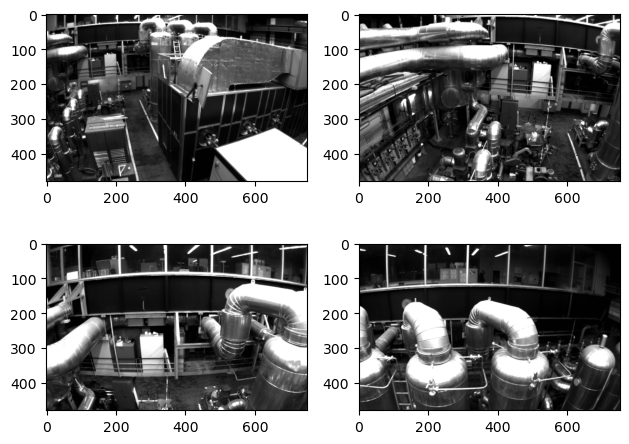

In [2]:
data_loader = proj.DataSetLoader("drone")
data_loader.show_dataset_images()

## 4.0 Results and Discussion
TODO

## 5.0 Conclusion and Future Work
TODO

## References

[1] Peter Lindstorm, (2010), "Triangulation Made Easy"

[2] Hartley and Zisserman, "Multiview Geometry, Chapter 12: Triangulation"
[2*] Beardsley, Zisserman and Murray, (1994) "Navigation using affine structure from motion"

[3] Lee and Civera, (2019), "Closed Form Optimal Two-View Triangulation Based on Angular Errors"

[4] Lee and Civera, "Triangulation: Why optimize?"

[5] Amy Tabb, "N-view triangulation: DLT method", URL: https://amytabb.com/tips/tutorials/2021/10/31/triangulation-DLT-2-3/

[6] Shree Nayar, "Structure From Motion Problem" URL: https://www.youtube.com/watch?v=JlOzyyhk1v0
[6a] Shree Nayar, "Epipolar Geometry: Uncalibrated Stereo", URL: https://www.youtube.com/watch?v=6kpBqfgSPRc
[6c] D Nister, (2004), "An Efficient Solution to the Five--point Relative Pose Problem", URL: http://16720.courses.cs.cmu.edu/lec/two-view2.pdf

[7] Tippetts et al. (2016), "Review of stereo vision algorithms and their suitability for resource-limited systems"

[8] C Campos et al. (2020), "ORB-SLAM3"
[8a] Li, Snavely, Huttenlocher, "Location Recognition using Prioritized Feature Matching" URL: https://www.cs.cornell.edu/projects/p2f/

[9] Stachniss, (2020), "Triangualtion from Image Pairs", URL: https://www.youtube.com/watch?v=UZlRhEUWSas&t=143s\
[9a] R. Sara, (2012), "The Triangulation Problem", URL: http://cmp.felk.cvut.cz/cmp/courses/TDV/2012W/lectures/tdv-2012-07-anot.pdf

[10] Triggs et al. (1992), "Bundle Adjustment - a modern synthesis"

[11] Kanatani and Niitsuma, (1995), "Reliability of 3D reconstruction by stereo vision" 

[12] Burri et al. (2016), "The EuRoC micro aerial vehicle datasets"

[13] Kamal and Barbalata, (2024), "Solving Short-Term Relocalization Problems In Monocular Keyframe
Visual SLAM Using Spatial And Semantic Data", Accepted in IEEE AIM 2024

[14] OpenCV, "Triangulation" URL: https://docs.opencv.org/4.x/d0/dbd/group__triangulation.html

[] D Lowe, (2004) "Scale-Invariant Feature Transform", URL: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

[] BigSFM: Reconstructing the World from Internet Photos, URL: https://www.cs.cornell.edu/projects/bigsfm/

[] PyYML, "PyYML", URL: https://python.land/data-processing/python-yaml

[] Numba, "A ~5 minutes guide to Numba", URL: https://numba.pydata.org/numba-doc/dev/user/5minguide.html

